In [641]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import string
from math import pi
from matplotlib import colors
from shapely.geometry import Point, Polygon

%matplotlib inline

pd.options.mode.chained_assignment = None

# Best places to live and work in the U.S. : Climate
This notebook represents the "Climate" section of a larger project.

I'm in my second year of undergrad, so naturally I've been thinking a lot about where to live once I graduate. In this project, I will explore data to augment my decision making. This project was heavily inspired by the list of best places to live by [U.S. Real Estate News](https://realestate.usnews.com/places/rankings/best-places-to-live). Their list is very compelling, and I was curious about their methods. I also found it difficult to compare two cities. So I decided to jump in myself!

Before we get started, I want to mention [weatherspark](https://weatherspark.com/), which is a website that I found while working on this project. They probably have the best climate visualizations out there, so go check it out! 

## Problem definition
What is the profile of each major city in the U.S.? I'll look at climate, population, and economy, as well as other factors that might be subjective and hard to measure (such as recreation, culture, religiosity, sports-ness, and political distribution). The focus of this experiment, compared to the U.S Real Estate News list is:
* Make it easier to compare two or more cities against any parameter or a set of parameters
* Consider how things are changing (e.g. 'What will the cost of living be in 10 years?' instead of 'What is the cost of living now?')
* Investigate other factors that are not covered by U.S. Real Estate News

## Data & cleaning/processing

### Cities
As a starting point, we need a list of cities. The list of metropolitan areas (hitherto referred to as cities) used in this experiment was obtained from [Wikipedia](https://en.wikipedia.org/wiki/List_of_metropolitan_statistical_areas) and downloaded using [wikitable2csv](https://wikitable2csv.ggor.de/). We'll be referring to this list for the rest of the project.

In [642]:
cities = pd.read_csv(
    '../data/raw/metros.csv',
    usecols=[1, 2], # for climate analysis, let's just pull out the city name and the population
    header=0,
    names=['Metro', 'Pop']
)
cities.head()

,Metro,Pop
0,"New York-Newark-Jersey City, NY-NJ-PA MSA","20,320,876"
1,"Los Angeles-Long Beach-Anaheim, CA MSA","13,353,907"
2,"Chicago-Naperville-Elgin, IL-IN-WI MSA","9,533,040"
3,"Dallas-Fort Worth-Arlington, TX MSA","7,399,662"
4,"Houston-The Woodlands-Sugar Land, TX MSA","6,892,427"


I (frustratingly) figured out that some of the metro descriptions actually have en dashes instead of hyphens. This caused some problems, so let's replace those.

In [643]:
def fix_dashes(city):
    return city['Metro'].replace(u'\u2013', '-') 

cities['Metro'] = cities.apply(
    lambda city: fix_dashes(city), # apply the function defined above
    axis=1 # apply function row-wise
)

### Climate
Climate data are from the [NOAA 1981-2010 normals](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/climate-normals/1981-2010-normals-data). Several tables from the NOAA normals are used: temperature average, temperature min, temperature max, cloud cover, average windspeed, precipitation, and snowfall. An important thing to note is that the tables do not have column names. The data are labelled by weather station ID, which are inventoried in various files (there are different stations available for different varieties of metrics, e.g. not all stations collect hourly data). This means we're going to have to treat the tables as a relational database, using the station inventory as a lookup table. 

The values in the climate tables are 30-year normals (averages). Each value is actually accurate to one tenth of whatever the unit is (percent, degrees farenheit, inches, MPH, etc), but it is represented as an int. There's also a character that describes the nature of the calculation of the value, but we can disregard that for our purposes. So, 85.4 degrees farenheit will look like `854C` in the tables. This means we're going to have to do some cleaning before we can analyze the data.

In order to connect cities with weather stations, we'll need their latitude and longitude. I retrieved this information from [OpenDataSoft](https://public.opendatasoft.com/explore/dataset/1000-largest-us-cities-by-population-with-geographic-coordinates/table/?sort=-rank&dataChart=eyJxdWVyaWVzIjpbeyJjb25maWciOnsiZGF0YXNldCI6IjEwMDAtbGFyZ2VzdC11cy1jaXRpZXMtYnktcG9wdWxhdGlvbi13aXRoLWdlb2dyYXBoaWMtY29vcmRpbmF0ZXMiLCJvcHRpb25zIjp7InNvcnQiOiItcmFuayJ9fSwiY2hhcnRzIjpbeyJhbGlnbk1vbnRoIjp0cnVlLCJ0eXBlIjoiY29sdW1uIiwiZnVuYyI6IkFWRyIsInlBeGlzIjoicmFuayIsInNjaWVudGlmaWNEaXNwbGF5Ijp0cnVlLCJjb2xvciI6IiNGRjUxNUEifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6NTAsInNvcnQiOiIifV0sInRpbWVzY2FsZSI6IiIsImRpc3BsYXlMZWdlbmQiOnRydWUsImFsaWduTW9udGgiOnRydWV9). This dataset actually has all the same fields as the Wikipedia data as well, but this dataset is about a decade older so I want to keep the population and population growth data from Wikipedia.

In [644]:
cities_latlong = pd.read_csv(
    '../data/raw/cities-lat-long.csv',
    sep=';',
    usecols=['City', 'State', 'Coordinates']
)
cities_latlong.head()

,City,State,Coordinates
0,South San Francisco,California,"37.654656, -122.4077498"
1,Aliso Viejo,California,"33.5676842, -117.7256083"
2,Rapid City,South Dakota,"44.0805434, -103.2310149"
3,Coon Rapids,Minnesota,"45.1732394, -93.3030063"
4,Malden,Massachusetts,"42.4250964, -71.066163"


Now we can join `cities` and `cities_latlong`. There is one intermediate step - we have to pull out the major city name from `cities.'Metropolitan statistical area'` to join it on `cities_latlong.'City'`. While we're at it, let's pull out the state and put it in its own column.

In [645]:
def major_city(city):
    """ Given a metro, return the predominant city name. """ 
    metro = city['Metro']
    metro = metro[0: metro.find(',')]
    term = metro.find('-')
    if term == -1:
        return metro
    return metro[0:term]

def state(city):
    """ Given a metro, return the state abbreviation. """
    metro = city['Metro']
    states = metro[metro.find(',') + 2:]
    state = states[0:2]
    if state == 'DC':
        state = 'MD'
    return state

cities['City'] = cities.apply(lambda city: major_city(city), axis=1)
cities['State'] = cities.apply(lambda city: state(city), axis=1)
cities.head()

,Metro,Pop,City,State
0,"New York-Newark-Jersey City, NY-NJ-PA MSA","20,320,876",New York,NY
1,"Los Angeles-Long Beach-Anaheim, CA MSA","13,353,907",Los Angeles,CA
2,"Chicago-Naperville-Elgin, IL-IN-WI MSA","9,533,040",Chicago,IL
3,"Dallas-Fort Worth-Arlington, TX MSA","7,399,662",Dallas,TX
4,"Houston-The Woodlands-Sugar Land, TX MSA","6,892,427",Houston,TX


At this point, we could try to join `cities_latlong` on `'City'`, but we would run into an issue. There are some cities that share a name. For example, Portland OR and Portland ME.

In [646]:
cities.duplicated(subset='City', keep=False).value_counts()

False    334
True      49
dtype: int64

This means that there are 49 entries using the same name as another city. This would create unexpected results if we joined `cities` with `cities_latlong` on `'City'`. It's tempting to just drop the duplicate rows to avoid the issue, but that leaves out some key cities like Portland ME. Here's another idea: let's change the value for `'City'` of the duplicate with the lower population to the second city in the `'Metropolitan Statistical Area'` column. That won't work either, because many of the problematic cities aren't actually a metro at all, e.g. Springfield MO. It seems like the only option is to somehow join based on the city name AND the state. Fortunately, `cities_latlong` has a column for state. Unfortunately, it's not the two-letter abbreviation that shows up in `cities`. We're going to have to find a way to map the abbreviations to the state names.

I pulled a table from [this website](https://statetable.com/) that will help.

In [647]:
state_table = pd.read_csv(
    '../data/raw/state-table.csv',
    usecols=[1, 2],
    header=0,
    names=['State name', 'State abbreviation']
)
state_table.head()

,State name,State abbreviation
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [648]:
cities = cities.merge(
    state_table,
    how='left',
    left_on='State',
    right_on='State abbreviation'
)
cities.head()

,Metro,Pop,City,State,State name,State abbreviation
0,"New York-Newark-Jersey City, NY-NJ-PA MSA","20,320,876",New York,NY,New York,NY
1,"Los Angeles-Long Beach-Anaheim, CA MSA","13,353,907",Los Angeles,CA,California,CA
2,"Chicago-Naperville-Elgin, IL-IN-WI MSA","9,533,040",Chicago,IL,Illinois,IL
3,"Dallas-Fort Worth-Arlington, TX MSA","7,399,662",Dallas,TX,Texas,TX
4,"Houston-The Woodlands-Sugar Land, TX MSA","6,892,427",Houston,TX,Texas,TX


In [649]:
cities['Duplicate'] = cities.duplicated(subset='City', keep='first') 
# the values are sorted by population, so keep='first' allows us to ignore the more populous city
cities.loc[cities['Duplicate']]

,Metro,Pop,City,State,State name,State abbreviation,Duplicate
104,"Portland-South Portland, ME MSA","532,083",Portland,ME,Maine,ME,True
114,"Springfield, MO MSA","462,369",Springfield,MO,Missouri,MO,True
137,"Fayetteville, NC MSA","386,662",Fayetteville,NC,North Carolina,NC,True
162,"Columbus, GA-AL MSA","303,811",Columbus,GA,Georgia,GA,True
201,"Lafayette-West Lafayette, IN MSA","219,239",Lafayette,IN,Indiana,IN,True
203,"Rochester, MN MSA","218,280",Rochester,MN,Minnesota,MN,True
208,"Charleston, WV MSA","214,406",Charleston,WV,West Virginia,WV,True
214,"Springfield, IL MSA","208,697",Springfield,IL,Illinois,IL,True
221,"Gainesville, GA MSA","199,335",Gainesville,GA,Georgia,GA,True
224,"Jacksonville, NC MSA","193,893",Jacksonville,NC,North Carolina,NC,True


In [650]:
cities = cities.merge(cities_latlong, how='inner', left_on=['City', 'State name'], right_on=['City', 'State'])
cities.head()

,Metro,Pop,City,State_x,State name,State abbreviation,Duplicate,State_y,Coordinates
0,"New York-Newark-Jersey City, NY-NJ-PA MSA","20,320,876",New York,NY,New York,NY,False,New York,"40.7127837, -74.0059413"
1,"Los Angeles-Long Beach-Anaheim, CA MSA","13,353,907",Los Angeles,CA,California,CA,False,California,"34.0522342, -118.2436849"
2,"Chicago-Naperville-Elgin, IL-IN-WI MSA","9,533,040",Chicago,IL,Illinois,IL,False,Illinois,"41.8781136, -87.6297982"
3,"Dallas-Fort Worth-Arlington, TX MSA","7,399,662",Dallas,TX,Texas,TX,False,Texas,"32.7766642, -96.7969879"
4,"Houston-The Woodlands-Sugar Land, TX MSA","6,892,427",Houston,TX,Texas,TX,False,Texas,"29.7604267, -95.3698028"


Now our dataframe has lat/long coordinates as well. We should separate the latitude and longitude into 2 columns.

In [651]:
cities[['Latitude', 'Longitude']] = cities['Coordinates'].str.split(', ', 1, expand=True).astype(float)
cities.dtypes

Metro                  object
Pop                    object
City                   object
State_x                object
State name             object
State abbreviation     object
Duplicate                bool
State_y                object
Coordinates            object
Latitude              float64
Longitude             float64
dtype: object

To keep things tidy, let's remove all the columns that we don't need. I'm also going to remove the 'MSA' from the metro descriptions.

In [652]:
cities = cities.drop(['City', 'Coordinates', 'State_x', 'State_y', 'Duplicate'], axis=1)
cities['Metro'] = cities.apply(lambda x: x['Metro'][:x['Metro'].find(' MSA')], axis=1)
cities.head()

,Metro,Pop,State name,State abbreviation,Latitude,Longitude
0,"New York-Newark-Jersey City, NY-NJ-PA","20,320,876",New York,NY,40.712784,-74.005941
1,"Los Angeles-Long Beach-Anaheim, CA","13,353,907",California,CA,34.052234,-118.243685
2,"Chicago-Naperville-Elgin, IL-IN-WI","9,533,040",Illinois,IL,41.878114,-87.629798
3,"Dallas-Fort Worth-Arlington, TX","7,399,662",Texas,TX,32.776664,-96.796988
4,"Houston-The Woodlands-Sugar Land, TX","6,892,427",Texas,TX,29.760427,-95.369803


I'm going to save this version of the table for other analyses.

In [653]:
cities.to_csv('../data/processed/cities.csv', index=False)

For the rest of the climate investigation, we only need the metro, state abbreviation, lat, and lon.

In [654]:
cities = cities.drop(['Pop', 'State name'], axis=1)
cities.head()

,Metro,State abbreviation,Latitude,Longitude
0,"New York-Newark-Jersey City, NY-NJ-PA",NY,40.712784,-74.005941
1,"Los Angeles-Long Beach-Anaheim, CA",CA,34.052234,-118.243685
2,"Chicago-Naperville-Elgin, IL-IN-WI",IL,41.878114,-87.629798
3,"Dallas-Fort Worth-Arlington, TX",TX,32.776664,-96.796988
4,"Houston-The Woodlands-Sugar Land, TX",TX,29.760427,-95.369803


### Defining data handling behavior 
We're going to be reading a few different tables, so let's define a function to handle reading the climate files..

### Preparing data for analysis
The last step before we can start our investigation is transforming the tables into something usable. The climate tables vary between monthly, daily, and hourly values and are labelled by weather station. I'd like to consolidate all the data into one format and label the data by cities instead of stations. So there are two things to do:
1. **Transform data to a common format.** I think monthly numbers are a sufficient level of fidelity for my purposes, so I can just aggregate all hourly and daily values into monthly values. 
2. **Change labels from stations to cities.** This is a little bit trickier. We're going to have to match cities with stations by minimizing the euclidean distance, calculated from latitude and longitude. 

I'll start by defining a function to handle item 2. Then, we can handle item 1. We'll define functions to convert the data to the analysis format.

In [ ]:
def find_station(city, table, stations_file):
    """ 
    Given a row for a city and the stations table filepath,
    return the ID of the closest weather station. 
    TODO: if the station that is found has too many NULLs, 
          remove that station from consideration and return
          the next closest station
    """
    
    metro = city['Metro']
    lat, lon = city['Latitude'], city['Longitude']
    state = city['State abbreviation']
    if state == 'DC':
        state = 'MD'
    # FIXME: D.C. creates problems joining the metro table with the weather station table
    #        maybe just hand-pick a weather station for D.C.?
    stations = pd.read_csv(
            stations_file,
            sep='\s+',
            header=None,
            names=['ID', 'LAT', 'LON', '_', 'STATE', 'NAME', '_', '_', '_', '_', '_', '_'],
            usecols=['ID', 'LAT', 'LON', 'STATE']
    )
    stations = stations.merge(
        table,
        how='inner',
        left_on='ID',
        right_on='STATION'
    )
    state_stations = stations[stations['STATE'] == state]
    state_stations['distances'] = state_stations.apply(
        lambda row: (row['LAT'] - lat)**2 + (row['LON'] - lon)**2,
        axis=1
    )
    return state_stations.loc[state_stations['distances'].idxmin()]['ID']

In [ ]:
def mly_to_analysis(table, stations_file):
    """
    Given a monthly climate table, return the table transformed
    to the analysis format.
    """
    # start with a copy of the cities table
    result = cities.copy()
    
    # add a column for the matching weather station
    result['Station'] = result.apply(lambda x: find_station(x, table, stations_file), axis=1)
    
    # the station found may not be in the table, because stations with too many NULLs 
    # will be dropped
        
    # join with climate data
    result = result.merge(
        table,
        how='inner',
        left_on='Station',
        right_on='STATION',
        copy=False
    ).drop(['STATION'], axis=1)
    
    result['Average'] = result.apply(lambda x: x[5:].mean(), axis=1)
    
    return result

def dly_to_analysis(table, stations_file):
    """
    Given a daily climate table, return the table transformed
    to the analysis format.
    TODO
    """
    # start with a copy of the cities table
    result = cities.copy()
    
    # add a column for the matching weather station
    result['Station'] = result.apply(lambda x: find_station(x, table, stations_file), axis=1)
    
    # prepare aggregate column of climate data
    table['Month average'] = table.apply(lambda x: x[2:].mean(), axis=1)
    
    # get the subset of the table that we're interested in
    table = table[['STATION', 'MONTH', 'Month average']]
    
    # pivot so that each month is a column instead of a row, using the average for the value
    table = table.pivot(
        index='STATION',
        columns='MONTH',
        values='Month average'
    )
    
    # join with climate data
    result = result.merge(
        table,
        how='inner',
        left_on='Station',
        right_on='STATION',
        copy=False
    )
    
    result['Average'] = result.apply(lambda x: x[5:].mean(), axis=1)
    
    return result

def hly_to_analysis(table, stations_file):
    """
    Given an hourly climate table, return the table transformed
    to the analysis format.
    TODO
    """
    
    # start with a copy of the cities table
    result = cities.copy()

    # add a column for the matching weather station
    result['Station'] = result.apply(lambda x: find_station(x, table, stations_file), axis=1)

    # prepare aggregate column of climate data
    table['Day average'] = table.apply(lambda x: x[3:].mean(), axis=1)

    # get the subset of the table that we're interested in
    table = table[['STATION', 'MONTH', 'DAY', 'Day average']]

    # aggregate day averages 
    table = table.groupby(by=['STATION', 'MONTH']).agg('mean').drop(['DAY'], axis=1).reset_index().pivot(
        index='STATION',
        columns='MONTH',
        values='Day average'
    )

    # join with climate data
    result = result.merge(
        table,
        how='inner',
        left_on='Station',
        right_on='STATION',
        copy=False
    )    
    
    result['Average'] = result.apply(lambda x: x[5:].mean(), axis=1)
    
    return result    

Now we just need a function to read an NOAA file and turn it into a dataframe, so we can pass that dataframe to the function above.

In [ ]:
# map of integers to month descriptions
months_map = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

def _clean(value, mag):
    """
    Define the behavior to clean values;
    to be used in read_climate_table.
    """
    # remove letters
    value = int(str(value).strip(string.ascii_letters)) / mag
    
    # treat missing values as NULLs
    if (value == -9999 / mag or
        value == -8888 / mag or
        value == -7777 / mag or 
        value == -6666 / mag or
        value == -5555 / mag):
        value = None
    return value

def read_climate_table(file, inv, form='None'):
    """ 
    Return a dataframe from a NOAA
    given a filepath and a format, 
    either 'mly', 'dly', or 'hly'.
    """
    
    cols = [
        'STATION',
        1, 2, 3, 4,
        5, 6, 7, 8,
        9, 10, 11, 12
    ] # numbers are months
    
    # describes the column at which the climate measurements start
    # preceding this column is station (and month (and day))
    values_start = 1
    
    if form == 'dly':
        cols = [
            'STATION', 'MONTH',
            1,2,3,4,5,6,7,8,9,10,
            11,12,13,14,15,16,17,18,19,20,
            21,22,23,24,25,26,27,28,29,30,
            31
        ] # numbers are days of the month
        values_start = 2
        
    if form == 'hly':
        cols = [
            'STATION', 'MONTH', 'DAY',
            1,2,3,4,5,6,7,8,
            9,10,11,12,13,14,15,16,
            17,18,19,20,21,22,23,24
        ] # numbers are hours of the day
        values_start = 3
    
    # read the table file
    df = pd.read_table(
        file,
        sep='\s+',
        header=None,
        names=cols
    )
    
    # values are represented in tenths (or 100ths for the precipitation file)
    if 'prcp' in file and 'ge' not in file:
        mag = 100
    else:
        mag = 10
        
    # apply _clean to all values except weather station
    df.iloc[:, values_start:] = df.iloc[:, values_start:].apply(
        lambda x: x.apply(
            lambda y: _clean(y, mag)
        ), axis=1
    )
    
    # drop stations with too many missing values
    if form == 'dly':
        df = df.dropna(thresh=4)
    else:
        df = df.dropna()
         
    # convert to analysis format
    if form == 'mly':
        df =  mly_to_analysis(df, inv)
    elif form == 'dly':
        df = dly_to_analysis(df, inv)
    elif form == 'hly':
        df = hly_to_analysis(df, inv)
        
    # lastly, rename months columns
    return df.rename(mapper=months_map, axis=1)

Now, we can read the NOAA data into dataframes.

In [ ]:
# daily high temperature
temp_hi = read_climate_table(
    '../data/raw/climate/dly-tmax-normal.txt',
    '../data/raw/climate/temp-inventory.txt',
    form='dly'
)

# daily low temperature
temp_lo = read_climate_table(
    '../data/raw/climate/dly-tmin-normal.txt',
    '../data/raw/climate/temp-inventory.txt',
    form='dly'
)

# monthly rainfall in inches
rain = read_climate_table(
    '../data/raw/climate/mly-prcp-normal.txt',
    '../data/raw/climate/prcp-inventory.txt',
    form='mly'
)

# daily probability of 1 or more inches of rain
# rain_prob = read_climate_table(
#     '../data/raw/climate/dly-prcp-pctall-ge100hi.txt',
#     '../data/raw/climate/prcp-inventory.txt',
#     form='dly'
# )

# monthly snowfall in inches
snow = read_climate_table(
    '../data/raw/climate/mly-snow-normal.txt',
    '../data/raw/climate/prcp-inventory.txt',
    form='mly'
)

# daily probability of 1 or more inches of snow
# snow_prob = read_climate_table(
#     '../data/raw/climate/dly-snow-pctall-ge010ti.txt',
#     '../data/raw/climate/hly-inventory.txt',
#     form='dly'
# )


# hourly dewpoint temperature
dewpoint = read_climate_table(
    '../data/raw/climate/hly-dewp-normal.txt',
    '../data/raw/climate/hly-inventory.txt',
    form='hly'
)


# hourly overcast percentage
clouds = read_climate_table(
    '../data/raw/climate/hly-clod-pctovc.txt',
    '../data/raw/climate/hly-inventory.txt',
    form='hly'
)


# hourly windspeed
wind = read_climate_table(
    '../data/raw/climate/hly-wind-avgspd.txt',
    '../data/raw/climate/hly-inventory.txt',
    form='hly'
)

Now, I'm going to save each of these so I never have to worry about that ever again.

In [ ]:
temp_hi.to_csv('../data/processed/temp-hi.csv', index=False)
temp_lo.to_csv('../data/processed/temp-lo.csv', index=False)
rain.to_csv('../data/processed/rain.csv', index=False)
snow.to_csv('../data/processed/snow.csv', index=False)
dewpoint.to_csv('../data/processed/dewpoint.csv', index=False)
clouds.to_csv('../data/processed/clouds.csv', index=False)
wind.to_csv('../data/processed/wind.csv', index=False)

Now I can load these tables from the files I just created.

In [ ]:
# temp_hi = pd.read_csv('../data/processed/temp-hi.csv')
# temp_lo = pd.read_csv('../data/processed/temp-lo.csv')
# rain = pd.read_csv('../data/processed/rain.csv')
# snow = pd.read_csv('../data/processed/snow.csv')
# dewpoint = pd.read_csv('../data/processed/dewpoint.csv')
# clouds = pd.read_csv('../data/processed/clouds.csv')
# wind = pd.read_csv('../data/processed/wind.csv')

## Investigation
Now we're ready to do some investigation.

### Mapping features
Let's make some maps to help our brains process the climate data. We'll do this with GeoPandas.

We'll need a shapefile map of the US. I'm using the states_21basic map from [ARC GIS](https://www.arcgis.com/home/item.html?id=f7f805eb65eb4ab787a0a3e1116ca7e5). I learned about how to use the map from [this article](https://medium.com/@erikgreenj/mapping-us-states-with-geopandas-made-simple-d7b6e66fa20d).

In [ ]:
import geopandas as gpd

usa = gpd.read_file('../data/raw/maps/states_21basic/states.shp')

# let's drop hawaii and alaska, because they make plotting very difficult
contig_usa = usa.drop(
    usa[usa['STATE_NAME'] == 'Hawaii'].index
).drop(
    usa[usa['STATE_NAME'] == 'Alaska'].index
)

#contig_usa will be passed to the plot function
contig_usa.head()

In order to plot the cities with geopandas, we'll have to turn the DataFrame into a GeoDataFrame. You can learn how to do this from the [GeoPandas documentation](https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html). Learn about colormaps from the [matplotlib documentation](https://matplotlib.org/users/colormaps.html#colorcet).

In [ ]:
def climate_gdf(df=None):
    """
    Return a GDF for geospatial plotting from a regular dataframe with latitude and longitude columns.
    """
    df['Coordinates'] = list(zip(df['Longitude'], df['Latitude']))
    df['Coordinates'] = df['Coordinates'].apply(Point)

    # make the GDF
    # exclude Alaska because it is hard to put on a map
    gdf = gpd.GeoDataFrame(df[~(df['State abbreviation'] == 'AK')], geometry='Coordinates')
    return gdf

Let's define a function to make the map for us.

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

def _climate_plot(gdf=None, month=1, cmap='Greens', base=None):
    w = widgets.IntSlider(
        value=1,
        min=1,
        max=12,
        step=1,
        description='Month:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )
    
    fig, ax = plt.subplots(1, 1, figsize=(10,6), dpi=200)
    sb.set(style='white')
    ax.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
    )
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    base_plot = base.plot(color='0.6', edgecolor='white', ax=ax)
    layer = gdf.plot(
        markersize=20,
        ax=ax,
        alpha=1,
        column=months_map[month],
        cmap=cmap,
        legend=True,
        vmin=gdf.iloc[:,5:17].min().min(), vmax=gdf.iloc[:,5:17].max().max()
    )
    plt.title(months_map[month])
    ax.axis('off')
    plt.show()
    
def climate_plot(gdf=None, cmap='Greens', base=None):
    interact_manual(
        _climate_plot,
        month=widgets.IntSlider(min=1,max=12,step=1,value=1),
        gdf=fixed(gdf),
        cmap=fixed(cmap),
        base=fixed(base)
    )

In [ ]:
climate_plot(
    gdf=climate_gdf(df=clouds),
    base=contig_usa,
    cmap='viridis_r'
)

## City profiling
Let's try taking a look at individual cities. I currently live in Fort Collins, Colorado.

In [ ]:
foco = 'Fort Collins, CO'

I wanted to try to making circular plots of climate features, since the year is actually a cycle. I defined a function to do exactly that. The U.S average is also plotted.

In [ ]:
def climate_radarplot(cities, df=None, ax=1, title=None):
    labels=np.array([
        'JAN', 'FEB', 'MAR', 'APR',
        'MAY', 'JUN', 'JUL', 'AUG',
        'SEP', 'OCT', 'NOV', 'DEC'
    ])
    
    df_min = df[5:17].min()[5:17].min()
    df_max = df[5:17].max()[5:17].max()
    
    row = df.loc[df['Metro'] == cities[0]].iloc[0][5:17]
    if len(cities) > 1:
        color2 = 'b'
        row2 = df.loc[df['Metro'] == cities[1]].iloc[0][5:17]
    else:
        color2 = '0.6'
        row2 = df.iloc[:,5:17].apply(lambda x: x.mean())
    
    row = row.fillna(row.mean())
    
    # set angles
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    
    # make arrays circular
    row = np.concatenate((row,[row[0]]))
    row2 = np.concatenate((row2, [row2[0]]))
    angles = np.concatenate((angles,[angles[0]]))
    
    # set y axis
    ax.set_ylim(df_min, df_max)
    ax.set_yticks(np.arange(df_min, df_max, (df_max - df_min) / 5))
    
    # draw the plot
    ax.plot(angles, row, '-', linewidth=2, color='r')
    ax.fill(angles, row, alpha=0.25, color='r')
    
    ax.plot(angles, row2, '-', linewidth=2, color=color2)
    ax.fill(angles, row2, alpha=0.15, color=color2)
    
    # set labels
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.grid(True)
    if title != None:
        ax.set_title(title, y=1.2)

In [ ]:
fig = plt.figure(figsize=(12,12), dpi=100)
climate_radarplot([foco], df=temp_hi, ax=fig.add_subplot(3,3,1, polar=True), title='High temp')
climate_radarplot([foco], df=temp_lo, ax=fig.add_subplot(3,3,2, polar=True), title='Low temp')
climate_radarplot([foco], df=rain, ax=fig.add_subplot(3,3,3, polar=True), title='Rainfall')
climate_radarplot([foco], df=snow, ax=fig.add_subplot(3,3,4, polar=True), title='Snowfall')
climate_radarplot([foco], df=dewpoint, ax=fig.add_subplot(3,3,5, polar=True), title='Dewpoint')
climate_radarplot([foco], df=clouds, ax=fig.add_subplot(3,3,6, polar=True), title='% overcast')
climate_radarplot([foco], df=wind, ax=fig.add_subplot(3,3,7, polar=True), title='Windspeed')
plt.subplots_adjust(top=1.1)

In [ ]:
fig.savefig('../output/figures/foco.png', dpi=800, bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(12,12), dpi=100)
nyc = cities.iloc[0]['Metro']
climate_radarplot([foco, nyc], df=temp_hi, ax=fig.add_subplot(3,3,1, polar=True), title='High temp')
climate_radarplot([foco, nyc], df=temp_lo, ax=fig.add_subplot(3,3,2, polar=True), title='Low temp')
climate_radarplot([foco, nyc], df=rain, ax=fig.add_subplot(3,3,3, polar=True), title='Rainfall')
climate_radarplot([foco, nyc], df=snow, ax=fig.add_subplot(3,3,4, polar=True), title='Snowfall')
climate_radarplot([foco, nyc], df=dewpoint, ax=fig.add_subplot(3,3,5, polar=True), title='Dewpoint')
climate_radarplot([foco, nyc], df=clouds, ax=fig.add_subplot(3,3,6, polar=True), title='% overcast')
climate_radarplot([foco, nyc], df=wind, ax=fig.add_subplot(3,3,7, polar=True), title='Windspeed')
plt.subplots_adjust(top=1.1)

In [ ]:
fig.savefig('../output/figures/foco-seattle.png', dpi=800, bbox_inches='tight')

Next, I'd like to use this same style of plot to create a shape that represents the profile of the city, using the annual averages. In order to put all the climate features on the same plot, the values are going to have to be normalized. Let's define a function to do that, so we can throw all of our weather tables into it.

In [ ]:
from sklearn import preprocessing

def climate_normalize(df):
    sub = df.iloc[:,5:18]
    array = sub.values
    scaler = preprocessing.MinMaxScaler()
    array_scaled = scaler.fit_transform(array)
    result = pd.DataFrame(
        array_scaled,
        columns=df.iloc[:,5:18].columns
    )
    result['Metro'] = df['Metro']
    return result

In [ ]:
temp_hi_norm = climate_normalize(temp_hi)
temp_lo_norm = climate_normalize(temp_lo)
rain_norm = climate_normalize(rain)
snow_norm = climate_normalize(snow)
dewpoint_norm = climate_normalize(dewpoint)
clouds_norm = climate_normalize(clouds)
wind_norm = climate_normalize(wind)

In [ ]:
def climate_profileplot(city, ax=None, title=None):
    # TODO: allow for plotting of two cities on top of each other
    # TODO: plot U.S. average
    
    labels=np.array([
        'HIGH', 'LOW', 'RAIN', 'SNOW',
        'DEWP', 'CLD', 'WIND'
    ])
    
#     average = [
#         temp_hi_[5:17].mean(),
#         temp_lo[5:17].mean(),
#         rain[5:17].mean(),
#         snow[5:17].mean(),
#         dewpoint[5:17].mean(),
#         clouds[5:17].mean(),
#         wind[5:17].mean()
#     ]
            
    stats = [
        temp_hi_norm[temp_hi_norm['Metro'] == city]['Average'].item(),
        temp_lo_norm[temp_lo_norm['Metro'] == city]['Average'].item(),
        rain_norm[rain_norm['Metro'] == city]['Average'].item(),
        snow_norm[snow_norm['Metro'] == city]['Average'].item(),
        dewpoint_norm[dewpoint_norm['Metro'] == city]['Average'].item(),
        clouds_norm[clouds_norm['Metro'] == city]['Average'].item(),
        wind_norm[wind_norm['Metro'] == city]['Average'].item()
    ]
        
    # set angles
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
    
    # make arrays circular
    stats = np.concatenate((stats,[stats[0]]))
#     average = np.concatenate((average, [average[0]]))
    angles = np.concatenate((angles,[angles[0]]))
    
    # set y axis
    ax.set_ylim(0, 1)
    ax.set_yticks(np.arange(0, 1, 0.2))
        
    # draw the plot
    ax.plot(angles, stats, '-', linewidth=2, color='y')
    ax.fill(angles, stats, alpha=0.25, color='y')
    
#     ax.plot(angles, average, '-', linewidth=2, color='0.6')
#     ax.fill(angles, average, alpha=0.15, color='0.6')
    
    # set labels
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.grid(True)
    ax.set_title(city[:city.find('-')], y=1.2)

In [ ]:
fig, axs = plt.subplots(
    nrows=3, ncols=3,
    figsize=(12,12), dpi=100,
    subplot_kw=dict(polar=True),
    gridspec_kw=dict(wspace=.6, hspace=1)
)
for i in range(3):
    for j in range(3):
        climate_profileplot(cities.iloc[(i*3)+j]['Metro'], ax=axs[i,j])
plt.show()

## Modeling
In order to use the climate evaluation as a parameter in this experiment, I think it would be best to come up with a climate classifier. Then we can add a new column to our data, `'Region'`, that will give us a good idea of what the weather is like there. 

The climate data are not labelled (i.e. there is no existing field `'Region'` describing cities that we could use to train a model), so we'll have to use an unsupervised learning technique. Let's try K means clustering from SciKit-Learn.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing

In [655]:
# make a new df for clustering,
# dropping all the columns except 
# for the features that we are going 
# to use for the model
cities_m = cities.copy()

cities_m = cities_m.merge(
    temp_hi[['Metro', 'Average']],
    how='inner', on='Metro'
).rename(mapper={'Average': 'Temp high average'}, axis=1)
cities_m = cities_m.merge(
    temp_lo[['Metro', 'Average']],
    how='inner', on='Metro'
).rename({'Average': 'Temp low average'}, axis=1)
cities_m = cities_m.merge(
    rain[['Metro', 'Average']],
    how='inner', on='Metro'
).rename({'Average': 'Rainfall average'}, axis=1)
cities_m = cities_m.merge(
    snow[['Metro', 'Average']],
    how='inner', on='Metro'
).rename({'Average': 'Snowfall average'}, axis=1)
cities_m = cities_m.merge(
    dewpoint[['Metro', 'Average']],
    how='inner', on='Metro'
).rename({'Average': 'Dewpoint average'}, axis=1)
cities_m = cities_m.merge(
    clouds[['Metro', 'Average']],
    how='inner', on='Metro'
).rename({'Average': 'Overcast average'}, axis=1)
cities_m = cities_m.merge(
    wind[['Metro', 'Average']],
    how='inner', on='Metro'
).rename({'Average': 'Windspeed average'}, axis=1)

cities_m.head()

,Metro,State abbreviation,Latitude,Longitude,Temp high average,Temp low average,Rainfall average,Snowfall average,Dewpoint average,Overcast average,Windspeed average
0,"New York-Newark-Jersey City, NY-NJ-PA",NY,40.712784,-74.005941,61.960593,47.873035,4.161667,2.150000,41.991137,33.414024,11.671907
1,"Los Angeles-Long Beach-Anaheim, CA",CA,34.052234,-118.243685,75.160122,55.668492,1.244167,0.000000,51.752355,23.602154,7.617234
2,"Chicago-Naperville-Elgin, IL-IN-WI",IL,41.878114,-87.629798,58.670449,45.028948,3.163333,2.450000,34.027500,35.729911,11.315741
3,"Dallas-Fort Worth-Arlington, TX",TX,32.776664,-96.796988,76.926714,57.352289,3.130833,0.091667,52.541427,27.533462,8.973261
4,"Houston-The Woodlands-Sugar Land, TX",TX,29.760427,-95.369803,79.473639,61.824416,4.749167,0.000000,60.283422,27.435479,7.957729


At this point I wonder, should latitude and longitude be used in the model? This would encourage the climate classification to classify regions, not just similar weather patterns.

Before we can do any clustering, we have to normalize the data.

In [656]:
sub = cities_m.iloc[:,4:]
metros = cities_m['Metro']
array = sub.values
scaler = preprocessing.MinMaxScaler()
array_scaled = scaler.fit_transform(array)
cities_m = pd.DataFrame(
    array_scaled,
    columns=sub.columns
)
cities_m['Metro'] = metros
cities_m.head()

,Temp high average,Temp low average,Rainfall average,Snowfall average,Dewpoint average,Overcast average,Windspeed average,Metro
0,0.384605,0.435199,0.736459,0.208401,0.415370,0.678429,0.858124,"New York-Newark-Jersey City, NY-NJ-PA"
1,0.678832,0.624935,0.181977,0.000000,0.636252,0.474620,0.394909,"Los Angeles-Long Beach-Anaheim, CA"
2,0.311266,0.365977,0.546722,0.237480,0.235164,0.726534,0.817435,"Chicago-Naperville-Elgin, IL-IN-WI"
3,0.718210,0.665917,0.540545,0.008885,0.654107,0.556280,0.549825,"Dallas-Fort Worth-Arlington, TX"
4,0.774983,0.774765,0.848115,0.000000,0.829297,0.554245,0.433808,"Houston-The Woodlands-Sugar Land, TX"


In [ ]:
sb.set(style='white')
sb.pairplot(data=cities_m)
fig = plt.gcf()
plt.show()

In [ ]:
fig.savefig('../output/figures/pairplot.png', dpi=800, bbox_inches='tight')

In [657]:
N = 8 # we have to specify the number of clusters
model = KMeans(n_clusters=N) 
model.fit(cities_m.iloc[:,0:-1].values) # the model takes a NumPy array as input
climate_clusters = model.predict(cities_m.iloc[:,0:-1].values)

The output of predict() is a NumPy 1D array containing the class for each row of the dataframe. This means we can just add this array to the dataframe as a new column.

In [658]:
cities_m['Climate cluster'] = climate_clusters # add to the normalized array for evaluation later
cities['Climate cluster'] = climate_clusters
cities.head()

,Metro,State abbreviation,Latitude,Longitude,Climate cluster
0,"New York-Newark-Jersey City, NY-NJ-PA",NY,40.712784,-74.005941,0
1,"Los Angeles-Long Beach-Anaheim, CA",CA,34.052234,-118.243685,4
2,"Chicago-Naperville-Elgin, IL-IN-WI",IL,41.878114,-87.629798,0
3,"Dallas-Fort Worth-Arlington, TX",TX,32.776664,-96.796988,2
4,"Houston-The Woodlands-Sugar Land, TX",TX,29.760427,-95.369803,3


I got the code for this discrete color map function from [github.com/jakevdp](https://gist.github.com/jakevdp/91077b0cae40f8f8244a).

In [ ]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    if base_cmap == None:
        return plt.cm.get_cmap(base_cmap, N)
    return base.from_list(cmap_name, color_list, N)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6), dpi=200)
sb.set(style='white')
ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
base_plot = contig_usa.plot(color='0.7', edgecolor='w', ax=ax)
layer = climate_gdf(cities).plot(
    markersize=20,
    ax=ax,
    alpha=1,
    column='Climate cluster',
    cmap=discrete_cmap(N, base_cmap='gist_rainbow'),
    legend=True
)
ax.axis('off')
plt.show()

In [ ]:
fig.savefig('../output/figures/clustermap.png', dpi=800, bbox_inches='tight')

Let's make an attempt to describe the climate clusters. To do so, we'll have to look at each cluster's distribution of each climate variable.

<Figure size 432x288 with 0 Axes>

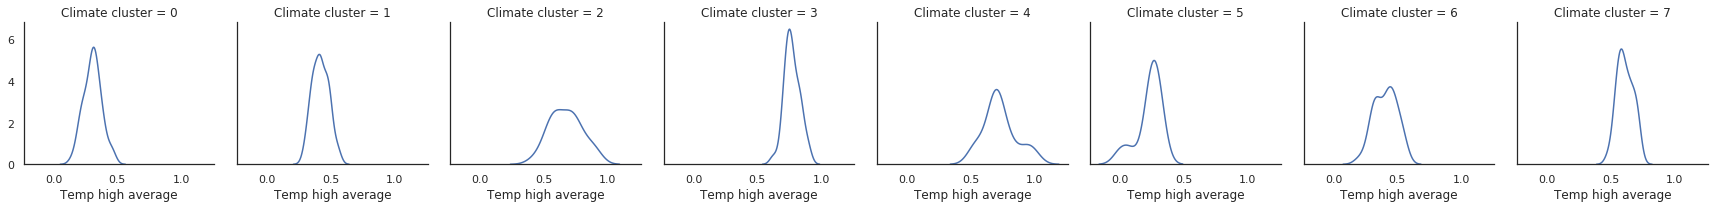

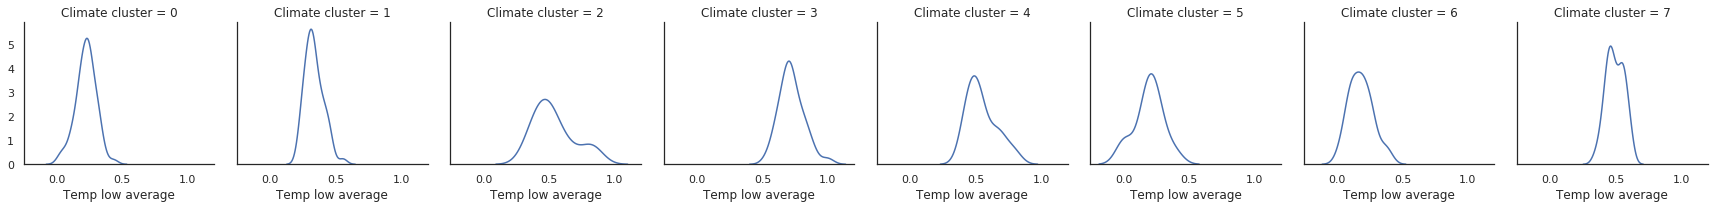

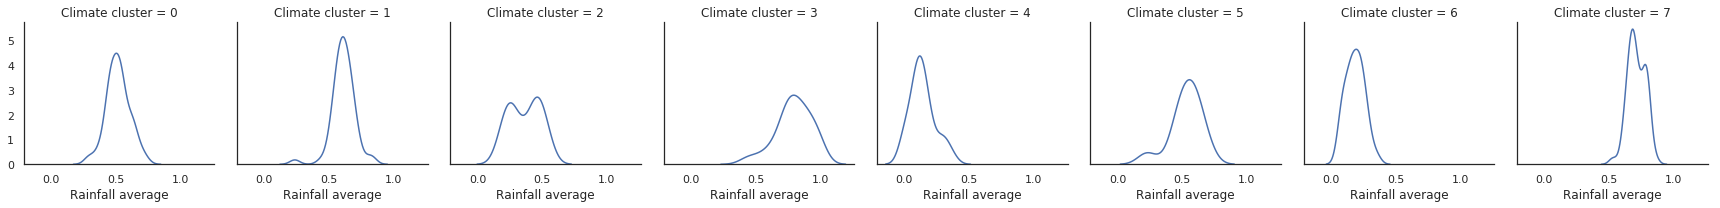

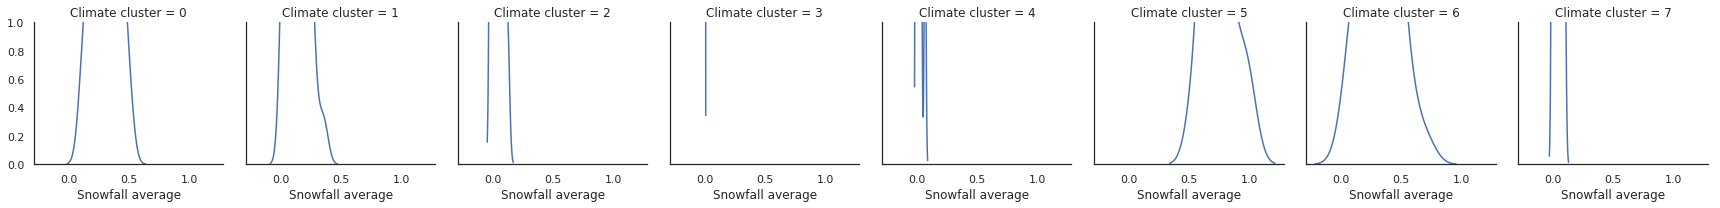

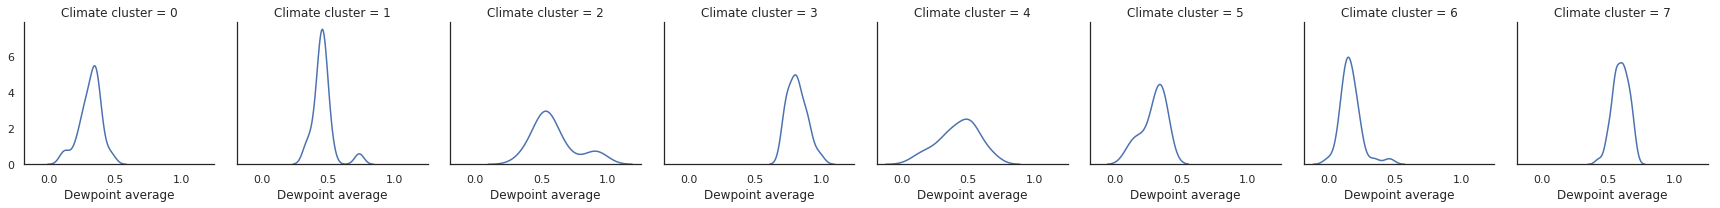

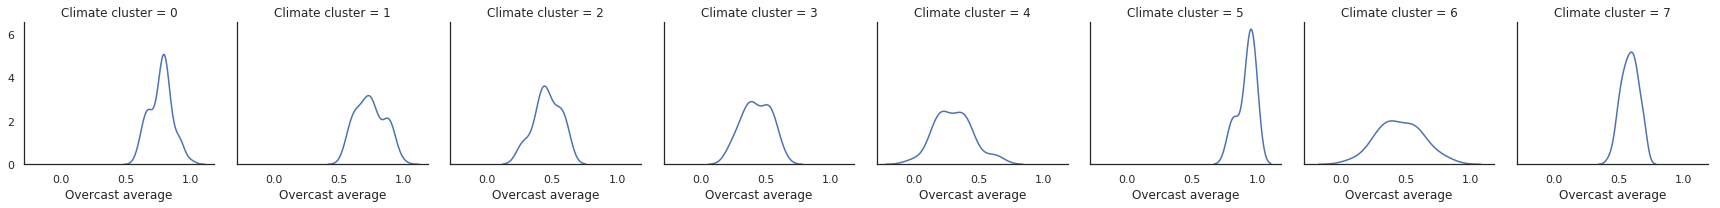

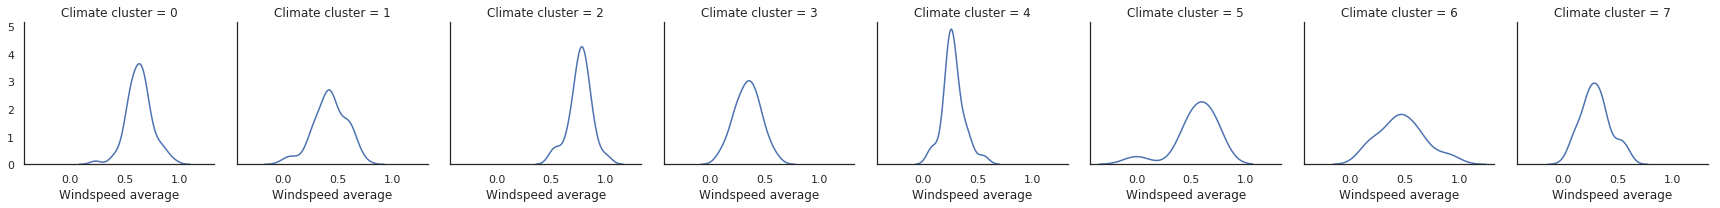

In [660]:
fig = plt.figure()

g = sb.FacetGrid(cities_m, col='Climate cluster')
g.map(sb.kdeplot, 'Temp high average')

g = sb.FacetGrid(cities_m, col='Climate cluster')
g.map(sb.kdeplot, 'Temp low average')

g = sb.FacetGrid(cities_m, col='Climate cluster')
g.map(sb.kdeplot, 'Rainfall average')

g = sb.FacetGrid(cities_m, col='Climate cluster', ylim=100)
g.map(sb.kdeplot, 'Snowfall average')

g = sb.FacetGrid(cities_m, col='Climate cluster')
g.map(sb.kdeplot, 'Dewpoint average')

g = sb.FacetGrid(cities_m, col='Climate cluster')
g.map(sb.kdeplot, 'Overcast average')

g = sb.FacetGrid(cities_m, col='Climate cluster')
g.map(sb.kdeplot, 'Windspeed average')

plt.show()

These plots describe the climate clusters. Let's create climate descriptors based on the distributions of climate variables.

In [ ]:
cluster_map = {
    0: 'Chilly/dry/snowy',
    1: 'Temperate/rainy/calm',
    2: 'Cold/snowy/cloudy',
    3: 'Hot/rainy/sticky/sunny/calm',
    4: 'Hot/rainy/sticky',
    5: 'Temperate/rainy/cloudy',
    6: 'Warm/windy',
    7: 'Cold/snowy/dry/cloudy/windy',
}
cities['Climate'] = cities.apply(lambda x: cluster_map[x['Climate cluster']], axis=1)
cities = cities.drop(['Climate cluster'], axis=1)
cities.head()

## Ranking cities
The whole point of this experiment is to figure out which cities have the best climate. We can do this by coming up with some ideal climate as a point in n-dimensional space, where n is the number of variables we've described. Then, we can rank cities in ascending order by their distance from this point. The cities closest to the point have the best climate.

When we calculate the distance, we're going to want to use the normalized values. Otherwise, a difference along the `cloud` axis might be more significant than a difference along the `wind` axis, because the `cloud` values vary much more.

The question is, what is the ideal climate? This is extremely subjective and even though I have a pretty good idea of weather that I like and don't like, I won't be able to come up with exact numbers to describe this. With all this in mind, I'll try my best.

In [ ]:
ideal = {
    'temp_hi': 0.5,
    'temp_lo': 0.4,
    'rain': 0.7,
    'dewpoint': 0.5,
    'snow': 0.2,
    'clouds': 0.5,
    'wind': 0
}

def evaluate_climate(city, ideal):
    """
    Given a city name and a dict describing the ideal climate,
    return the distance of that city in n-dimensional 
    space from the point representing the ideal climate.
    """
    edges = []
    edges.append((ideal['temp_hi']  - temp_hi_norm[temp_hi_norm['Metro'] == city].iloc[0]['Average']) ** 2)
    edges.append((ideal['temp_lo']  - temp_lo_norm[temp_lo_norm['Metro'] == city].iloc[0]['Average']) ** 2)
    edges.append((ideal['rain']     - rain_norm[rain_norm['Metro'] == city].iloc[0]['Average']) ** 2)
    edges.append((ideal['snow']     - snow_norm[snow_norm['Metro'] == city].iloc[0]['Average']) ** 2)
    edges.append((ideal['dewpoint'] - dewpoint_norm[dewpoint_norm['Metro'] == city].iloc[0]['Average']) ** 2)
    edges.append((ideal['clouds']   - clouds_norm[clouds_norm['Metro'] == city].iloc[0]['Average']) ** 2)
    edges.append((ideal['wind']     - wind_norm[wind_norm['Metro'] == city].iloc[0]['Average']) ** 2)
   
    return sum(edges)

In [ ]:
cities['Score'] = cities.apply(lambda x: evaluate_climate(x['Metro'], ideal), axis=1)
cities.head(50).sort_values('Score', ascending=True).head(10)['Metro']

I'm going to save a copy of this dataframe with the climate rankings.

In [ ]:
cities.sort_values(
    'Score', ascending=True
).reset_index().rename(
    mapper={'index': 'Climate rank'}, axis=1
).drop(
    ['Score', 'Coordinates'], axis=1
).to_csv('../data/processed/climate-rankings.csv')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,6), dpi=200)
sb.set(style='white')
ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
base_plot = contig_usa.plot(color='0.7', edgecolor='white', ax=ax)
layer = climate_gdf(cities).plot(markersize=20, ax=ax, alpha=1, column='Score', cmap='RdYlGn_r', legend=False)
ax.axis('off')
plt.show()

In [ ]:
fig.savefig('../output/figures/climate-rank-map.png', dpi=800, bbox_inches='tight')